#Catalogue


*   Introduction data

*   data preprocessing
*   Data visualization with product as the dimension
*   Data visualization was performed with the country as the dimension



# Introduction data


***Data S2 Name*** stands for a different product.

***Weight*** represents weights, which add up to approximately 100% for the same food item.

The following indicators are losses to the environment per 100g:

***Land Use (m²·year)***:  Total land area used.

***Arable Land Use (m²·year)***: Crop-growing land area.

**Pasture Land Use (m²·year)**: Grazing land area.

***Biodiversity (sp·yr·10^14)***: Impact on species diversity.

***GHG Emissions (kg CO₂eq)***: Greenhouse gas emissions.

***Acidification (g SO₂eq)***: Contribution to acid rain.

***Eutrophication (g PO₄³⁻eq)***: Nutrient pollution potential.

***Water Use (L)***: Total water used.

***Scarcity Weighted Water Use (L eq)***: Water usage considering scarcity

In [38]:
import pandas as pd


file_path = 'jp_lca_dat.csv'

try:
    data = pd.read_csv(file_path)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='ISO-8859-1')


#data preprocessing


 Find Vacant Values

In [40]:
# Replace '-' with NaN
data.replace('-', pd.NA, inplace=True)


columns_with_missing_values = data.columns[data.isna().any()]


print("Columns with missing values:", columns_with_missing_values)

# To get the count of missing values in each column
missing_value_counts = data.isna().sum()
print("Count of missing values per column:")
print(missing_value_counts[missing_value_counts > 0])  # Show only columns with missing values


Columns with missing values: Index(['Weight', 'Acidification (g SO2eq)'], dtype='object')
Count of missing values per column:
Weight                      3
Acidification (g SO2eq)    80
dtype: int64


##change col name in order to easy to select

In [41]:
import re

# define col name which need to change
feature_cols = [
    'Weight', 'Land Use (m2*year)', 'Arable Land Use (m2*year)',
    'Pasture Land Use (m2*year)', 'GHG Emissions (kg CO2eq, IPCC2013 incl CC feedbacks)',
    'Biodiversity (sp*yr*10^14)', 'Eutrophication (g PO43-eq)', 'Water Use (L)',
    'Scarcity Weighted Water Use (L eq)','Acidification (g SO2eq)'
]

# new col
new_col_names = []
for col in feature_cols:
    clean_col = re.sub(r"\s+\(.*\)", "", col)
    clean_col = clean_col.replace(" ", "_")
    new_col_names.append(clean_col)


col_rename_map = dict(zip(feature_cols, new_col_names))

data.rename(columns=col_rename_map, inplace=True)


print(data.columns)

Index(['Product id', 'Data S2 Name', 'Group', 'id', 'Product_details',
       'Country', 'Weight', 'Land_Use', 'Arable_Land_Use', 'Pasture_Land_Use',
       'Biodiversity', 'GHG_Emissions', 'Acidification', 'Eutrophication',
       'Water_Use', 'Scarcity_Weighted_Water_Use', 'Sys'],
      dtype='object')


In [42]:
# of vacant rows counted
null_count = data.isnull().any(axis=1).sum()
null_count

83

##Modifying outliers

There are three vacant values in the Weight column of the dataset, and through exploring the data, we learnt that the meaning of weight is that if we group the data according to the column of Data S2 Name, the weight of each group will add up very close to 100%, and the main reason for not being equal to 100% is that there is a lack of precision in the data. Therefore, for the missing values of weight, we will use 100% minus the known weights.

And there are values of zero, preliminary judgment for accuracy loss, shi'yon for them to fill 0.01.

In [43]:
import pandas as pd

# Check if the 'Weight' column is of string type, if so, perform string operations
if data['Weight'].dtype == object:
    data['Weight'] = pd.to_numeric(data['Weight'].str.replace('-', 'NaN').str.rstrip('%'), errors='coerce')
else:
    # If 'Weight' is already numeric but may contain incorrect data (like '-'), treat those as NaN
    data['Weight'] = pd.to_numeric(data['Weight'].replace('-', pd.NA), errors='coerce')
# Convert zero weights to 0.01
data['Weight'] = data['Weight'].replace(0, 0.01)

# Calculate the number of missing values for each 'Data S2 Name'
missing_counts = data.groupby('Data S2 Name')['Weight'].apply(lambda x: x.isna().sum())

# Calculate the sum of weights for non-missing values for each 'Data S2 Name'
weight_sums = data.groupby('Data S2 Name')['Weight'].sum()


fill_values = pd.DataFrame({
    'MissingCount': missing_counts,
    'WeightSum': weight_sums
})
fill_values['RemainingWeight'] = 100 - fill_values['WeightSum']


def calculate_fill_value(row):
    if row['RemainingWeight'] > 0:
        return row['RemainingWeight'] / row['MissingCount'] if row['MissingCount'] > 0 else 0
    else:
        return 0.01

fill_values['FillValue'] = fill_values.apply(calculate_fill_value, axis=1)


for index, row in fill_values.iterrows():
    fill_value = row['FillValue']
    data.loc[(data['Data S2 Name'] == index) & (data['Weight'].isna()), 'Weight'] = fill_value



Returns the sum of the weights grouped by Data S2 Name

In [44]:

if data['Weight'].dtype == object:
    data['Weight'] = pd.to_numeric(data['Weight'].str.replace('-', 'NaN').str.rstrip('%'), errors='coerce')
else:
    data['Weight'] = pd.to_numeric(data['Weight'].replace('-', pd.NA), errors='coerce')

weight_sum_by_data_s2_name = data.groupby('Data S2 Name')['Weight'].sum().reset_index()

weight_sum_by_data_s2_name

,Data S2 Name,Weight
0,Apples,99.84
1,Bananas,100.10
2,Barley (Beer),100.52
3,Beet Sugar,100.00
4,Berries & Grapes,99.30
5,Bovine Meat (beef herd),98.90
6,Bovine Meat (dairy herd),97.30
7,Brassicas,99.40
8,Cane Sugar,100.51
9,Cassava,100.00


For the missing values in the Acidification column, I use linear regression for prediction

In [45]:
from sklearn.linear_model import LinearRegression

data.replace('-', pd.NA, inplace=True)
# Define the column of features to be used for prediction
feature_cols = [
    'Weight', 'Land_Use', 'Arable_Land_Use', 'Pasture_Land_Use',
    'Biodiversity', 'GHG_Emissions',
    'Eutrophication', 'Water_Use', 'Scarcity_Weighted_Water_Use'
]

# Fill missing values in all numeric columns with the median to prevent deletion of too much data
for col in feature_cols:
    if data[col].dtype == float or data[col].dtype == int:
        data[col].fillna(data[col].median(), inplace=True)

# Record the original row index with missing values
missing_acidification_index = data[data['Acidification'].isna()].index

#Separation of data with and without missing values
train_data = data.dropna(subset=[*feature_cols, 'Acidification'])
predict_data = data.loc[missing_acidification_index, feature_cols]

X_train = train_data[feature_cols]
y_train = train_data['Acidification']
X_predict = predict_data


if X_train.empty:
    raise ValueError("empyty train data.....")

# 创建并训练模型
model = LinearRegression()
model.fit(X_train, y_train)

predicted_acidification = model.predict(X_predict)
predicted_acidification_rounded = [round(value, 2) for value in predicted_acidification]
data.loc[missing_acidification_index, 'Acidification'] = predicted_acidification_rounded
filled_acidification_data = data.loc[missing_acidification_index]


Make a copy of the original dataset

In [46]:
data_filled = data.copy()

Some pre-processing of the data format

In [47]:

# Converts the percentage in the Weight column to a numeric value
data_filled['Weight'] = data_filled['Weight'] / 100


environmental_indicators = [
    'Land_Use',
    'Biodiversity',
    'GHG_Emissions',
    'Acidification',
    'Eutrophication',
    'Water_Use',
    'Scarcity_Weighted_Water_Use'
]

# Check and convert to floating point
for indicator in environmental_indicators:
    try:
        data_filled[indicator] = pd.to_numeric(data_filled[indicator], errors='raise')
    except ValueError:
        print(f"Cannot convert {indicator} to a numeric type.")

# Create weighted columns with column names linked using underscores
for indicator in environmental_indicators:
    weighted_column_name = f'Weighted_{indicator}'
    try:
        data_filled[weighted_column_name] = data_filled['Weight'] * data_filled[indicator]
    except Exception as e:
        print(f"Failed to create weighted column for {indicator}: {str(e)}")



#Data visualization with product as the dimension

Create Data_S2_Name_Consumption, create a new column, multiply the weight by the index of the new column, in the classification summary, a total of 43 total products is the production of a product consumption of the indicators.

In [ ]:
weighted_indicators = [f'Weighted_{indicator.replace(" ", "_")}' for indicator in environmental_indicators]

# grouping and summing
grouped_data = data_filled.groupby('Data S2 Name')[weighted_indicators].sum()

# Reset Indexes to Convert Data S2 Name from Index to Column
Data_S2_Name_Consumption = grouped_data.reset_index()


new_column_names = {name: f'Data_S2_Name_{name.split("_", 1)[1]}' for name in Data_S2_Name_Consumption.columns[1:]}  # 除去第一个列名，即 'Data_S2_Name'
Data_S2_Name_Consumption = Data_S2_Name_Consumption.rename(columns=new_column_names)


An auxiliary graph is generated to study the relationship between different products and each metric

<ipython-input-58-b38323920a29>:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



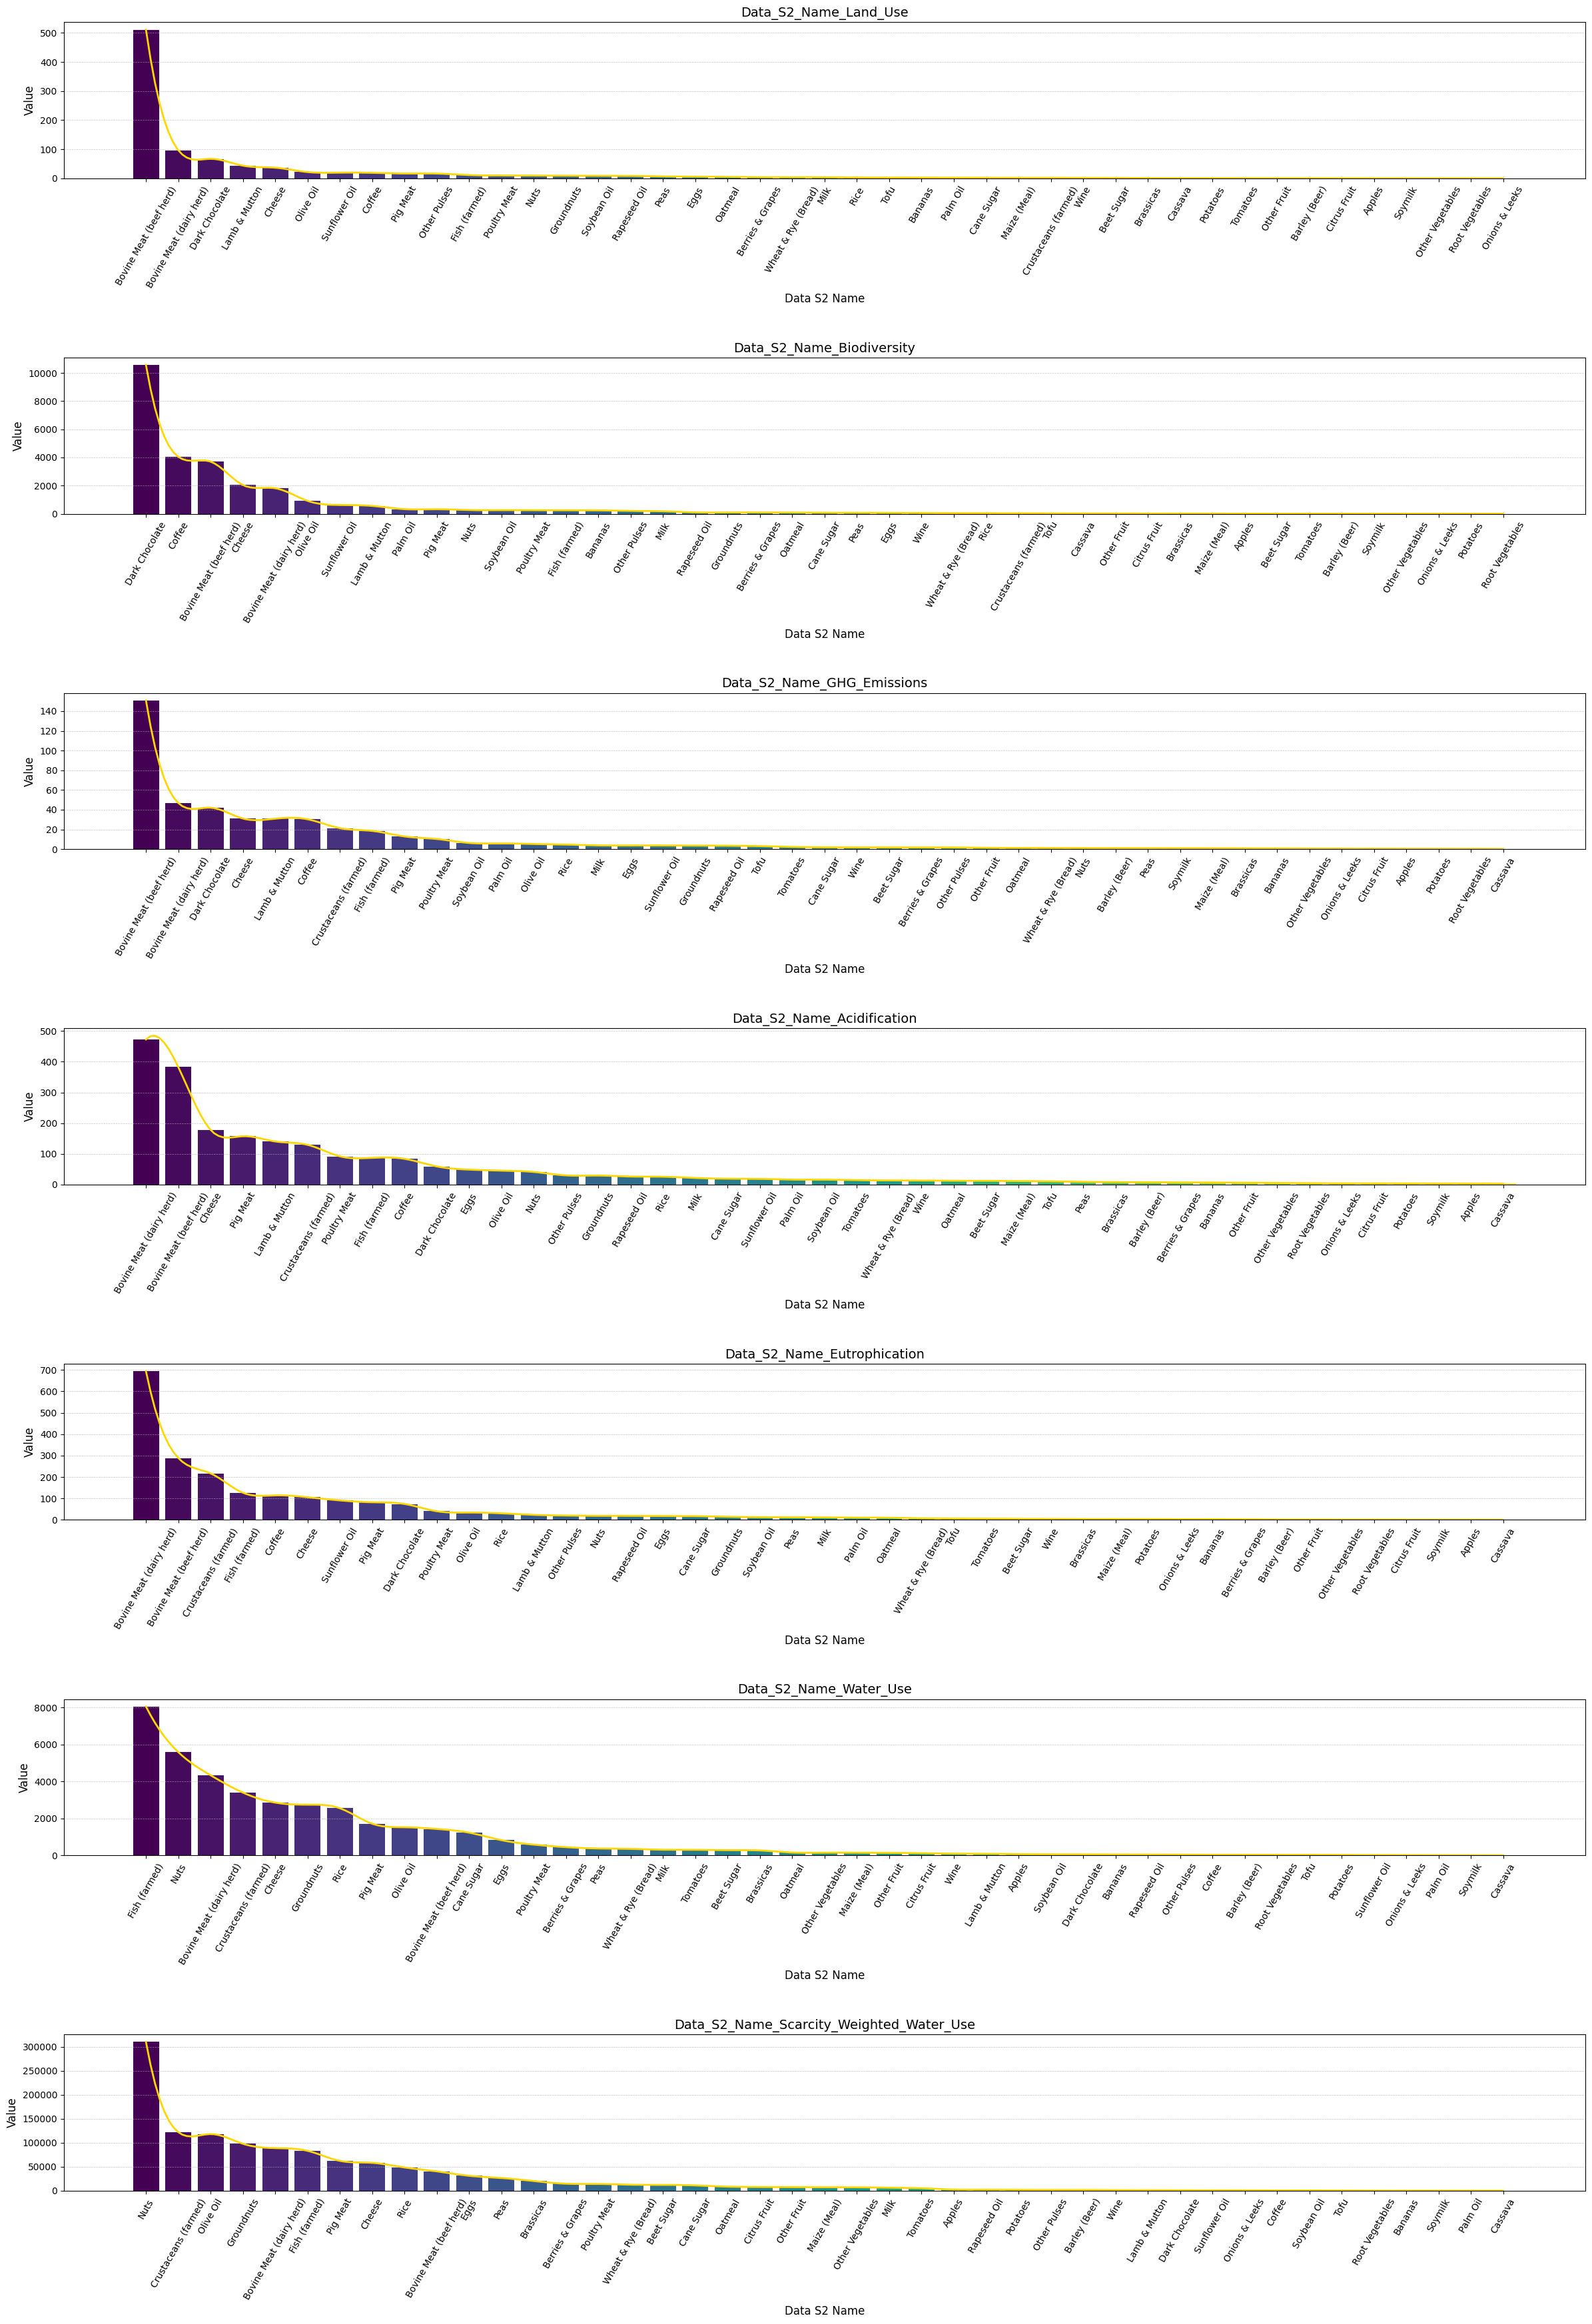

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from scipy.interpolate import make_interp_spline
from matplotlib.cm import viridis
# Environmental impact columns and labels
categories = [
    'Data_S2_Name_Land_Use', 'Data_S2_Name_Biodiversity', 'Data_S2_Name_GHG_Emissions',
    'Data_S2_Name_Acidification', 'Data_S2_Name_Eutrophication', 'Data_S2_Name_Water_Use',
    'Data_S2_Name_Scarcity_Weighted_Water_Use'
]

fig, axes = plt.subplots(7, 1, figsize=(24, 35))

viridis = get_cmap('viridis')

# Plot each environmental impact dimension
for i, category in enumerate(categories):

    sorted_data = Data_S2_Name_Consumption[['Data S2 Name', category]].sort_values(by=category, ascending=False)

    ax = axes[i]
    colors = viridis(np.linspace(0, 1, len(sorted_data)))
    ax.bar(sorted_data['Data S2 Name'], sorted_data[category], color=colors)


    x = np.arange(len(sorted_data))
    spl = make_interp_spline(x, sorted_data[category], k=3)
    smooth = np.linspace(x.min(), x.max(), 300)
    smooth_values = spl(smooth)
    ax.plot(smooth, smooth_values, color="gold", linewidth=2)

    ax.set_title(category, fontsize=14)
    ax.set_xlabel('Data S2 Name', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.tick_params(axis='x', rotation=60, labelsize=10)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout(h_pad=4)
plt.show()

The environmental indicators of Data_S2_Name_Consumption are normalized and multiplied by the corresponding weights (after multiple rounds of testing) to obtain a value, which can represent the degree of influence of 43 products on environmental degradation.Total_Product_Environmental_Impact is to calculate the environmental impact of each production of 100g of food.

In [59]:
from sklearn.preprocessing import MinMaxScaler
# Define the weight of each environmental indicator
weights = {
    'Data_S2_Name_Land_Use': 0.2,
    'Data_S2_Name_Biodiversity': 0.2,
    'Data_S2_Name_GHG_Emissions': 0.2,
    'Data_S2_Name_Acidification': 0.1,
    'Data_S2_Name_Eutrophication': 0.1,
    'Data_S2_Name_Water_Use': 0.1,
    'Data_S2_Name_Scarcity_Weighted_Water_Use': 0.1
}

scaler = MinMaxScaler()


for column, weight in weights.items():

    Data_S2_Name_Consumption[f'Normalized_{column}'] = scaler.fit_transform(Data_S2_Name_Consumption[[column]])


    Data_S2_Name_Consumption[f'Impact_{column}'] = Data_S2_Name_Consumption[f'Normalized_{column}'] * weight


Data_S2_Name_Consumption['Total_Product_Environmental_Impact'] = Data_S2_Name_Consumption[[f'Impact_{column}' for column in weights.keys()]].sum(axis=1)

Data_S2_Name_Consumption

,Data S2 Name,Data_S2_Name_Land_Use,Data_S2_Name_Biodiversity,Data_S2_Name_GHG_Emissions,Data_S2_Name_Acidification,Data_S2_Name_Eutrophication,Data_S2_Name_Water_Use,Data_S2_Name_Scarcity_Weighted_Water_Use,Normalized_Data_S2_Name_Land_Use,Impact_Data_S2_Name_Land_Use,...,Impact_Data_S2_Name_GHG_Emissions,Normalized_Data_S2_Name_Acidification,Impact_Data_S2_Name_Acidification,Normalized_Data_S2_Name_Eutrophication,Impact_Data_S2_Name_Eutrophication,Normalized_Data_S2_Name_Water_Use,Impact_Data_S2_Name_Water_Use,Normalized_Data_S2_Name_Scarcity_Weighted_Water_Use,Impact_Data_S2_Name_Scarcity_Weighted_Water_Use,Total_Product_Environmental_Impact
0,Apples,0.655687,8.772806,0.435430,3.150426,1.121235,61.071934,2281.747616,0.000543,1.085361e-04,...,0.000160,0.000469,0.000047,0.000665,0.000067,0.007583,0.000758,0.007350,0.000735,0.002028
1,Bananas,2.631610,240.770980,0.822150,6.599130,3.365030,46.127580,143.896910,0.004411,8.821777e-04,...,0.000674,0.007814,0.000781,0.003901,0.000390,0.005728,0.000573,0.000464,0.000046,0.007890
2,Barley (Beer),0.700727,5.773471,1.084337,7.314743,2.158544,27.013672,1566.638032,0.000631,1.261708e-04,...,0.001022,0.009338,0.000934,0.002161,0.000216,0.003354,0.000335,0.005047,0.000505,0.003234
3,Beet Sugar,1.469569,7.166113,1.838960,12.184736,4.873580,277.693476,12237.622736,0.002136,4.271988e-04,...,0.002024,0.019709,0.001971,0.006077,0.000608,0.034482,0.003448,0.039423,0.003942,0.012542
4,Berries & Grapes,4.070660,90.847340,1.726990,6.907320,3.290850,439.235700,14554.867730,0.007228,1.445615e-03,...,0.001875,0.008470,0.000847,0.003794,0.000379,0.054541,0.005454,0.046887,0.004689,0.016396
5,Bovine Meat (beef herd),511.189370,3705.626070,150.907390,382.644390,288.672820,1427.078820,40309.896360,1.000000,2.000000e-01,...,0.200000,0.808640,0.080864,0.415378,0.041538,0.177205,0.017720,0.129855,0.012986,0.623240
6,Bovine Meat (dairy herd),96.630360,1812.607770,46.786610,472.501560,694.034810,4333.098150,88837.436790,0.188430,3.768592e-02,...,0.061718,1.000000,0.100000,1.000000,0.100000,0.538054,0.053805,0.286183,0.028618,0.416126
7,Brassicas,1.011720,13.144480,0.868700,7.935690,4.073640,263.377000,20112.171160,0.001240,2.479352e-04,...,0.000735,0.010660,0.001066,0.004923,0.000492,0.032704,0.003270,0.064790,0.006479,0.012526
8,Cane Sugar,2.098795,71.415393,1.849198,19.040797,17.484751,1225.064118,11010.958612,0.003368,6.735624e-04,...,0.002038,0.034310,0.003431,0.024265,0.002427,0.152120,0.015212,0.035471,0.003547,0.028666
9,Cassava,0.935000,21.930000,0.315000,2.930000,0.660000,0.000000,0.000000,0.001089,2.178967e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000619


Generation of cobweb diagrams to observe the extent of environmental impacts caused by different products, based on the normalised indicators.

In [61]:
import plotly.graph_objs as go

columns_to_normalize = [
    'Data_S2_Name_Land_Use', 'Data_S2_Name_Biodiversity', 'Data_S2_Name_GHG_Emissions',
    'Data_S2_Name_Acidification', 'Data_S2_Name_Eutrophication', 'Data_S2_Name_Water_Use',
    'Data_S2_Name_Scarcity_Weighted_Water_Use'
]


# for column in columns_to_normalize:
#     Data_S2_Name_Consumption[f'Normalized_{column}'] = scaler.fit_transform(Data_S2_Name_Consumption[[column]])

# Prepare data for Plotly radar chart
categories = [f'Normalized_{col}' for col in columns_to_normalize]
display_categories = [col.replace('Data_S2_Name_', '') for col in columns_to_normalize]
fig = go.Figure()

# Plot each product on the radar chart
for _, row in Data_S2_Name_Consumption.iterrows():
    hover_info = f"<b>{row['Data S2 Name']}</b><br>"
    for col, display_col in zip(columns_to_normalize, display_categories):
        hover_info += f"{display_col}: {row[col]:.2f}<br>"

    fig.add_trace(go.Scatterpolar(
        r=row[categories].tolist(),
        theta=display_categories,
        fill='toself',
        name=row['Data S2 Name'],
        hovertemplate=hover_info
    ))


fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True),
        bgcolor='rgb(25, 25, 112)'
    ),
    showlegend=True,
    title='Environmental Impact Level (Normalized Value) by Product',
    width=1000,
    height=1000,
    legend=dict(
        x=1.1,
        xanchor='left',
    ),
    margin=dict(l=10, r=100, t=50, b=10)
)


fig.show()

Produce a bar chart showing the environmental impact of producing 100 grams of each food item (multiply the normalised indicators by the weights and add them up).

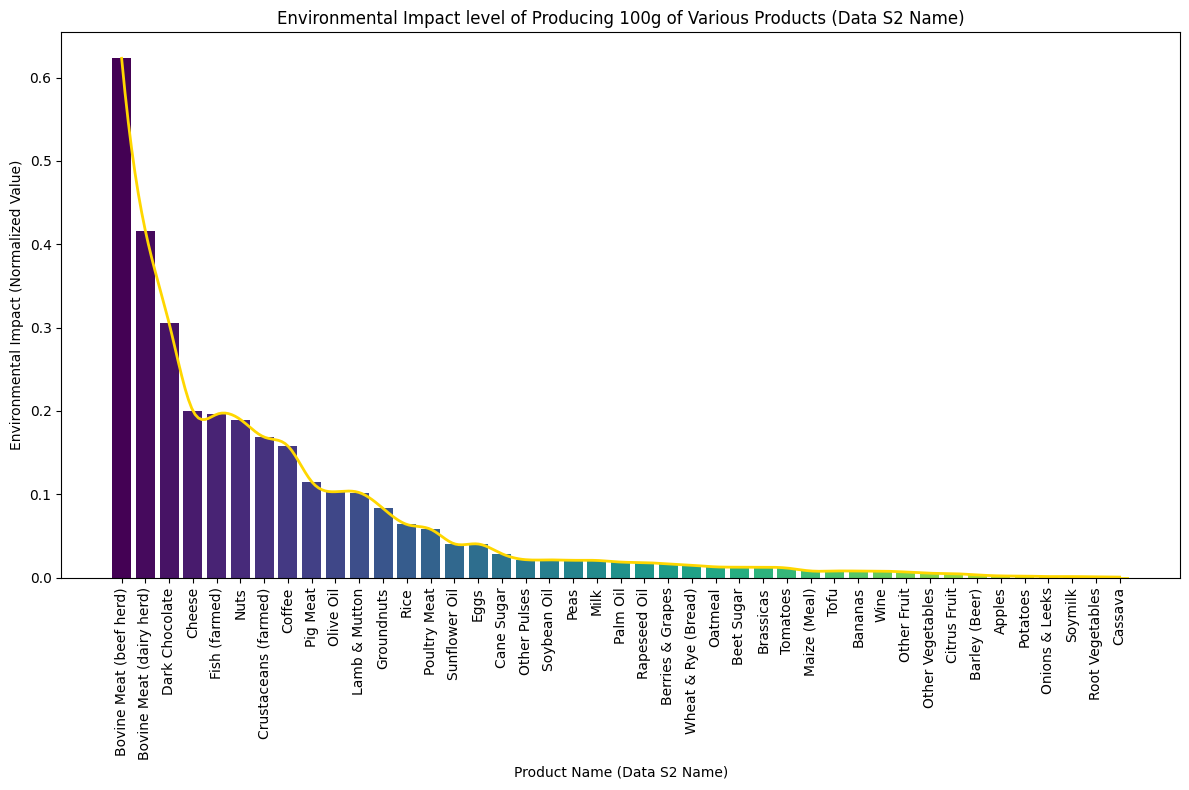

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import viridis
from scipy.interpolate import make_interp_spline

sorted_data = Data_S2_Name_Consumption.sort_values('Total_Product_Environmental_Impact', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

colors = viridis(np.linspace(0, 1, len(sorted_data)))
bars = ax.bar(sorted_data['Data S2 Name'], sorted_data['Total_Product_Environmental_Impact'], color=colors)

x = np.arange(len(sorted_data))

spl = make_interp_spline(x, sorted_data['Total_Product_Environmental_Impact'], k=3)
smooth = np.linspace(x.min(), x.max(), 300)
smooth_values = spl(smooth)
ax.plot(smooth, smooth_values, color="gold", linewidth=2)


ax.set_xlabel('Product Name (Data S2 Name)')
ax.set_ylabel('Environmental Impact (Normalized Value)')
ax.set_title('Environmental Impact level of Producing 100g of Various Products (Data S2 Name)')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

#Data visualization was performed with the country as the dimension

Now, the environmental indicators of filled_data are standardized and summarized according to the dimension of the country to detect the environmental impact of 43 products per 100g of production in different countries. Please note: Different countries produce different quantities and types of products.

In [ ]:

weighted_indicators = [f'Weighted_{indicator.replace(" ", "_")}' for indicator in environmental_indicators]

for indicator in weighted_indicators:
    max_value = data_filled[indicator].max()
    normalized_column_name = f'Normalized_by_Max_{indicator}'
    if max_value > 0:
        data_filled[normalized_column_name] = data_filled[indicator] / max_value
    else:
        data_filled[normalized_column_name] = 0

# Display the header of the modified DataFrame
print(data_filled.head())

   Product id         Data S2 Name        Group  id      Product_details  \
0           1  Wheat & Rye (Bread)  starch_rich   1          Wheat bread   
1           1  Wheat & Rye (Bread)  starch_rich   4          Wheat bread   
2           1  Wheat & Rye (Bread)  starch_rich   5  Wheat and rye bread   
3           1  Wheat & Rye (Bread)  starch_rich   6          Wheat bread   
4           1  Wheat & Rye (Bread)  starch_rich   7          Wheat bread   

     Country  Weight  Land_Use  Arable_Land_Use  Pasture_Land_Use  ...  \
0  Australia   0.009      7.78             7.78               0.0  ...   
1     France   0.014      5.42             5.42               0.0  ...   
2     France   0.014     29.28            29.28               0.0  ...   
3     France   0.002      1.44             1.44               0.0  ...   
4    Germany   0.011      1.31             1.31               0.0  ...   

   Weighted_Eutrophication  Weighted_Water_Use  \
0                  0.12546             0.08298  

In [ ]:
# Setting weights for individual environmental indicators
Normalized_weights = {
    'Normalized_by_Max_Weighted_Land_Use': 0.2,
    'Normalized_by_Max_Weighted_Biodiversity': 0.2,
    'Normalized_by_Max_Weighted_GHG_Emissions': 0.2,
    'Normalized_by_Max_Weighted_Acidification': 0.1,
    'Normalized_by_Max_Weighted_Eutrophication': 0.1,
    'Normalized_by_Max_Weighted_Water_Use': 0.1,
    'Normalized_by_Max_Weighted_Scarcity_Weighted_Water_Use': 0.1
}

# Calculation of weighted total environmental impact
data_filled['Total_Environmental_Impact_per_100g'] = sum(
    data_filled[col] * Normalized_weights for col, Normalized_weights in Normalized_weights.items()
)


print(data_filled[['Total_Environmental_Impact_per_100g']].head())

   Total_Environmental_Impact_per_100g
0                             0.000417
1                             0.000443
2                             0.001449
3                             0.000038
4                             0.000088


Total_Environmental_Impact_per_100g: Calculates, on a country-by-country basis, the environmental contribution of each country for the production of 100g of each commodity. For example, for every 100g of 43 bells of commodity produced, how much of Brazil's resources are consumed. This is because each country produces different food ingredients. However, assuming that the 43 bells of food are the main foodstuffs for human beings, and that the countries in the data are mainly the main producers of these types of foodstuffs, it is possible to calculate the environmental contribution of each country for each 100g of the total product produced.



In [ ]:
# Grouped by country and summed over 'Total_Environmental_Impact_per_100g'
grouped_by_country = data_filled.groupby('Country')['Total_Environmental_Impact_per_100g'].sum()

country_environmental_impact = grouped_by_country.reset_index()

country_environmental_impact.rename(columns={'Total_Environmental_Impact_per_100g': 'Total_Impact_per_Country'}, inplace=True)

country_environmental_impact

,Country,Total_Impact_per_Country
0,Argentina,0.038319
1,Australia,0.363560
2,Austria,0.009425
3,Bangladesh,0.321038
4,Belgium,0.000181
5,Benin,0.027874
6,Brazil,2.034133
7,Cameroon,0.002594
8,Canada,0.016497
9,Chile,0.001812


Generate a bar chart. The bar chart represents the environmental resources consumed to produce 100 g of 43 commodities in the following countries.

In [ ]:
import plotly.express as px


country_environmental_impact_sorted = country_environmental_impact.sort_values('Total_Impact_per_Country', ascending=False)


fig = px.bar(country_environmental_impact_sorted,
             x='Country',
             y='Total_Impact_per_Country',
             title='Environmental Resource Consumption level per 100g for 43 Products by Country',
             labels={'Total_Impact_per_Country': 'Total Environmental Impact', 'Country': 'Country'},
             color='Total_Impact_per_Country',
             color_continuous_scale=px.colors.sequential.Plasma)


fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Environmental Resource Consumption level",
    coloraxis_colorbar=dict(title="Impact level"),
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()

In [ ]:
pip install dash dash-core-components dash-html-components

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.0 MB/s eta 0:00:00


Generate a digital map。The map color shows the environmental resources consumed by all countries in the dataset for the production of 100 g of 43 products.

The map shows the environmental resources consumed by all countries in the dataset for the production of 100g of 43 products. Then when the mouse touches a different country, a bar graph is returned showing the proportion of the different products produced in that country. For example, France meat3% means that for every 100g of meat produced, 3% is produced in France.Accordingly, the environmental cost of the 3% of meat that comes from France will be calculated

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd


app = dash.Dash(__name__)


custom_colorscale = [
    [0.0, "green"],
    [(0.75 - 0) / (2 - 0), "yellow"],
    [(1.5 - 0) / (2 - 0), "orange"],
    [1.0, "red"]
]


app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id='country-map',
            figure=go.Figure(go.Choropleth(
                locations=country_environmental_impact['Country'],
                z=country_environmental_impact['Total_Impact_per_Country'],
                locationmode='country names',
                colorscale=custom_colorscale,
                colorbar_title='Environmental Resource Consumption level',
                zmin=0,
                zmax=2
            )).update_layout(
                title_text='Environmental Resource Consumption level per 100g for 43 Products by Country',
                title_x=0.5,
                geo=dict(
                    showframe=False,
                    showcoastlines=False,
                    projection_type='equirectangular'
                ),
                margin=dict(l=20, r=20, t=50, b=20)
            ),
            style={'width': '100%', 'height': '70vh'}
        )
    ]),

    html.Div([
        dcc.Graph(
            id='country-bar',
            figure=go.Figure(),
            style={'width': '100%', 'height': '30vh'}
        )
    ])
])


@app.callback(
    Output('country-bar', 'figure'),
    [Input('country-map', 'hoverData')]
)
def update_bar_chart(hoverData):

    if not hoverData:
        return go.Figure()

    country_name = hoverData['points'][0]['location']
    country_data = data_filled[data_filled['Country'] == country_name]
    weight_sum = country_data.groupby('Data S2 Name')['Weight'].sum().reset_index()

    adjusted_weights = weight_sum['Weight'] * 1.5

    fig = go.Figure(data=[
        go.Bar(x=weight_sum['Data S2 Name'], y=adjusted_weights)
    ])
    fig.update_layout(
        title_text=f'{country_name}Share in Food Production Among 58 Countries Food Production by Category)',
        xaxis_title="Product Name (Data S2 Name)",
        yaxis_title="Proportion of Production ",
        margin=dict(l=20, r=20, t=50, b=50)
    )

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)



<IPython.core.display.Javascript object>